In [1]:
from Bio import SeqIO
from Bio import AlignIO
from Bio import Phylo
import matplotlib.pyplot as plt
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio import SeqIO
from collections import Counter
import pandas as pd
from itertools import product
import re
import subprocess



In [2]:
def root_tree_with_first_sequence(tree, root_sequence):
    """
    Roots the tree file with the provided root sequence.

    Args:
    tree: The tree object to be rooted.
    root_sequence (str): The identifier of the sequence to be used as the root.

    Returns:
    rooted_tree_file (str): The path to the rooted tree file.
    """
    # Root the tree file with the outgroup
    rooted_tree_file = tree.root_with_outgroup(root_sequence)

    return rooted_tree_file



In [3]:
def get_reconstructed_ancestral_sequences(ancestral_state_file_path):
    """
    Reconstructs ancestral node sequences from the ancestral state file.
    
    Parameters:
        ancestral_state_file_path (str): The path to the ancestral state file.
    
    Returns:
        dict: A dictionary containing the reconstructed ancestral sequences, where the keys are the ancestral node ids and the values are the reconstructed sequences.
    """
    # Read the ancestral state file
    ancestral_states = pd.read_csv(ancestral_state_file_path, sep='\t', skiprows=8)
    # Concatenate the ancestral states for all the positions for a given ancestral node to reconstruct the sequence for that node
    ancestral_sequences = {}
    for node, group in ancestral_states.groupby('Node'):
        sequence = ''.join(group['State'])
        ancestral_sequences[node] = sequence
    
    return ancestral_sequences

In [4]:
#Function to compute the trinucleotide frequency of a sequence to be used in normalization step while computing the trinucleotide mutation rate
def get_kmer_frequency(sequence, k):
    """
    Calculate the frequency of k-mers in a given sequence.

    Args:
        sequence (str): The input RNA sequence.
        k (int): The length of the k-mer.

    Returns:
        kmers_frequency_dict: A dictionary containing all possible k-mers as keys and their frequencies in the input sequence as values.
    """
    # Remove gaps from the sequence
    sequence = sequence.replace("-", "")
    #Total number of kmers in the sequence
    total_kmers = len(sequence) - k + 1

    # Declare and Initialize the dictionary to store the kmer frequency by assigning all possible k-mers with frequency 0
    nucleotides = ["C", "T", "G", "A"]
    kmers_frequency_dict = {''.join(combo): 0 for combo in product(nucleotides, repeat=k)}

    # Iterate through the sequence to find all k-mers
    for i in range(total_kmers):
        kmer = sequence[i:i + k]  # Extract the k-mer
        # Check if the k-mer consists only of A, T, G, or C and not any other characters
        if set(kmer).issubset(set(nucleotides)):
            # Increment the frequency of this k-mer in the kmer_frequency dictionary
            kmers_frequency_dict[kmer] += 1  
    # Return the kmer dictionary
    return kmers_frequency_dict

In [5]:
def find_mutations_wrt_ancestral_sequence(ancestor_seq, sample_seq):
    """
    To compute the mutations by comparing each sequence against its nearest reconstructed ancestral sequence

    Args:
        ancestor_seq (str): The ancestor sequence.
        sample_seq (str): The sample sequence.

    Returns:
        mutations: A list of mutations, where each mutation is represented as a list containing the mutation, the trinucleotide context, and the trinucleotide frequency
    """
    # Initialize the list to store the mutations
    mutations = []
    # Get the trinucleotide mutation frequencies in the ancestor sequence
    trinucleotide_mutation_frequency = get_kmer_frequency(ancestor_seq, 3)
    # Iterate through each position and bases in the two sequences
    for i, (a, b) in enumerate(zip(ancestor_seq, sample_seq)):
        # If the base is different between the ancestor and sample sequences 
        if a != b:
            #position of the mutation in the alignment is index + 1
            position = i + 1  
            # Extract the trinucleotide context of the mutation
            trinucleotide = str(ancestor_seq[position-2:position+1]).upper()  
            # Base in the ancestor sequence
            ref_base = a.upper()
            # Base in the sample sequence
            sample_base = b.upper()
            # We ignore those mutations at the starting or end position of the alignment as their trinucleotide context cannot be captured
            # We also ignore those mutations in which the surrounding trinucleotide contains abnormal basses or the mutation itself contains abnormal bases
            if (
                any(base not in ["C", "T", "G", "A"] for base in trinucleotide) or
                any(base not in ["C", "T", "G", "A"] for base in [ref_base, sample_base]) or
                len(trinucleotide) != 3
            ):                
                continue
            else:
                # Record the mutation data which includes the mutation, its trinucleotide context and trinuleotide frequency 
                mutation = f"{ref_base}{position}{sample_base}".upper()
                mutations.append([mutation, trinucleotide, trinucleotide_mutation_frequency[trinucleotide]])
               
    return mutations


In [6]:
def find_ancestral_node(tree, node_name):
    """
    To find the nearest ancestral node to a particular node in the tree

    Args:
        tree: The phylogenetic tree to search in.
        node_name: The name of the node for which we wish to find the nearest ancestor.

    Returns:
        ancestral_node: The ancestral node if found, None otherwise.
    """
    # Search the target node in the tree
    target_node = next((clade for clade in tree.find_clades() if str(clade.name).split("/")[0] == node_name), None)
    if target_node is None:
        print(f"Node '{node_name}' not found.")
        return None

    # Traverse the tree to find the nearest ancestral node to the target node
    ancestral_node = None
    for clade in tree.find_clades():
        if target_node in clade:
            ancestral_node = clade
            break
    
    #return nearest ancestral node
    return ancestral_node



In [7]:

def get_mutation_data_for_internal_nodes(ancestral_sequences, msa_file_path, tree):
    """ 
    To compute the mutations for the internal nodes of the tree

    Args:
        ancestral_sequences (dict): Dictionary of reconstructed ancestral sequences.
        msa_file_path (str): The path to the mutiple sequence alignment file.
        tree: The phylogenetic tree.

    Returns:
         - denovo_mutations: A dictionary mapping each internal node to its denovo mutations.
         - ancestral_mutations: A dictionary mapping each internal node to its ancestral mutations.
         - ancestral_node_data: A dictionary mapping each internal node to its nearest ancestral node.

    """
    # Initialize the dictionaries to store the mutation data
    denovo_mutations = {}
    ancestral_mutations = {}
    ancestral_node_data = {}

    # Sort the ancestral nodes based on their node number
    ancestral_nodes = list(ancestral_sequences.keys())
    ancestral_nodes = sorted(ancestral_nodes, key=lambda node: int(re.search(r'\d+', node).group()))

    for node in ancestral_nodes:
        #If it is the initial node, then the reference sequence is used as the ancestral sequence
        if node == "Node1":
            reference_record = next(SeqIO.parse(msa_file_path, "fasta"), None)
            reference_id = reference_record.id
            reference_seq = str(reference_record.seq).upper()
            denovo_mutations[node] = find_mutations_wrt_ancestral_sequence(reference_seq, ancestral_sequences[node])
            ancestral_mutations[node] = []
            ancestral_node_data["Node1"] = reference_id
        #If it is not the initial node, then we find the nearest ancestor and compute the mutations against it
        else:
            ancestral_node = find_ancestral_node(tree, node)
            denovo_mutations[node] = find_mutations_wrt_ancestral_sequence(
                ancestral_sequences[str(ancestral_node).split("/")[0]], ancestral_sequences[node]
            )
            ancestral_mutations[node] = (
                denovo_mutations[str(ancestral_node).split("/")[0]]
                + ancestral_mutations[str(ancestral_node).split("/")[0]]
            )
            ancestral_node_data[node] = ancestral_node

    return denovo_mutations, ancestral_mutations, ancestral_node_data


In [8]:

def get_mutation_data_for_leaf_nodes(alignment_file, ancestral_sequences, denovo_mutations, ancestral_mutations, tree, ancestral_node_data):
    """
    To compute the mutations for the leaf nodes of the tree
    
    Parameters:
    - alignment_file (str): Path to the multiple sequence alignment file .
    - ancestral_sequences (dict): Dictionary of reconstructed ancestral sequences.
    - denovo_mutations (dict): Dictionary to store denovo mutations. 
    - ancestral_mutations (dict): Dictionary to store ancestral mutations. 
    - tree: the Phylogenetic tree object.
    - ancestral_node_data (dict): Dictionary to store ancestral node data.

    Returns:
    - denovo_mutations (dict): Updated dictionary of denovo mutations.
    - ancestral_mutations (dict): Updated dictionary of ancestral mutations.
    - ancestral_node_data (dict): Updated dictionary of ancestral node data for each leaf node.
    """
    # Get the leaf node names from the alignment file    
    leaf_nodes = [record.id for record in SeqIO.parse(alignment_file, "fasta")]
    #As the first leaf node is the reference sequence, we need to handle it separately
    denovo_mutations[leaf_nodes[0]] = []
    ancestral_mutations[leaf_nodes[0]] = []
    #Remove the reference sequence from the leaf nodes
    leaf_nodes = leaf_nodes[1:]
    #Compute the mutations for each leaf node
    for leaf_node in leaf_nodes:
        #find its nearest ancestral node data
        ancestral_node = find_ancestral_node(tree, leaf_node)
        #store the ancestral node data for the leaf node
        ancestral_node_data[leaf_node] = ancestral_node
        #extract the sequence of this leaf node
        sequence = next((str(record.seq).upper() for record in SeqIO.parse(alignment_file, "fasta") if record.id == leaf_node), None)
        #compute the mutations against the nearest ancestral sequence
        denovo_mutations[leaf_node] = find_mutations_wrt_ancestral_sequence(
            ancestral_sequences[str(ancestral_node).split("/")[0]], 
            sequence)
        #bootstrapping during tree construction can modify the names of the nodes in the tree by including the bootstrap results, hence we need to extract only the node name from the tree
        #and use it to save mutation data for that leafnode
        ancestral_mutations[leaf_node] = denovo_mutations[str(ancestral_node).split("/")[0]] + ancestral_mutations[str(ancestral_node).split("/")[0]]
    return denovo_mutations, ancestral_mutations, ancestral_node_data



For each of the samples, we access the precomputed MSA files and the precomputed tree file. As IQTREE does not automatically root the tree with the outgroup hence we do it explicitly. Also, we use the ancestral states at each ancestral nodes of the tree to reconstruct the probable ancestral sequences.

In [9]:
import os
import pickle

sample_size=3600
folder_path="../Samples/"
outgroup_id = "NC_045512.2"  

for sample in os.listdir(folder_path):
    print(sample)
    #path to the MSA file
    alignment_file_path = os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_{sample_size}+1_msa.fasta")
    tree_path = os.path.join(folder_path, sample, f"{sample}.treefile")
    tree = Phylo.read(tree_path, "newick")
    root_tree_with_first_sequence(tree, outgroup_id)
    #we now reconstruct the ancestral sequences of the tree from the ancestral state file
    ancestral_sequences=get_reconstructed_ancestral_sequences(os.path.join(folder_path, sample, f"{sample}.state"))

    #we now compute the mutations for the internal nodes of the tree
    denovo_mutations, ancestral_mutations,ancestral_node_data=get_mutation_data_for_internal_nodes(ancestral_sequences,alignment_file_path, tree)

    #we now compute the mutations for the leaf nodes of the tree   
    denovo_mutations, ancestral_mutations,ancestral_node_data=get_mutation_data_for_leaf_nodes(alignment_file_path,ancestral_sequences, denovo_mutations, ancestral_mutations,tree,ancestral_node_data)

    #we extract the mutations for the leaf nodes(sampled genomes) of the tree
    denovo_mutations_in_sampled_genomes = {key: value for key, value in denovo_mutations.items() if not key.startswith("Node")}
    denovo_mutations_in_sampled_genomes.pop(outgroup_id)
    ancestral_mutations_in_sampled_genomes = {key: value for key, value in denovo_mutations.items() if not key.startswith("Node")}
    ancestral_mutations_in_sampled_genomes.pop(outgroup_id)

    def save_pickle(data, filepath):
        # Ensure the directory exists
        dir_path = os.path.dirname(filepath)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        try:
            with open(filepath, 'wb') as f:
                pickle.dump(data, f)
            print(f"Data successfully saved to {filepath}")
        except Exception as e:
            print(f"Error saving to {filepath}: {e}")

    # Save denovo mutations
    save_pickle(denovo_mutations_in_sampled_genomes, os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_denovo_mutations_in_sampled_genomes.pkl"))

    # Save ancestral mutations
    save_pickle(ancestral_mutations_in_sampled_genomes, os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_ancestral_mutations_in_sampled_genomes.pkl"))


Sample_1
Data successfully saved to ../Samples/Sample_1/SARS-CoV-2_Sample_1_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_1/SARS-CoV-2_Sample_1_ancestral_mutations_in_sampled_genomes.pkl
Sample_10
Data successfully saved to ../Samples/Sample_10/SARS-CoV-2_Sample_10_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_10/SARS-CoV-2_Sample_10_ancestral_mutations_in_sampled_genomes.pkl
Sample_11
Data successfully saved to ../Samples/Sample_11/SARS-CoV-2_Sample_11_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_11/SARS-CoV-2_Sample_11_ancestral_mutations_in_sampled_genomes.pkl
Sample_12
Data successfully saved to ../Samples/Sample_12/SARS-CoV-2_Sample_12_denovo_mutations_in_sampled_genomes.pkl
Data successfully saved to ../Samples/Sample_12/SARS-CoV-2_Sample_12_ancestral_mutations_in_sampled_genomes.pkl
Sample_13
Data successfully saved to ../Samples/Sample_13/SARS-CoV-2_Sample_13_de

In [20]:
def get_trinucleotide_mutation_rates(denovo_mutations):
    """
    Computed and returns the trinucleotide mutation Rate for a sample.

    Args:
        denovo_mutations (dict): The dictionary containing the denovo mutations data for the sampled genomes.
    """
    # Generate all possible trinucleotide combinations
    flank_length=1
    nucleotides=["C", "T", "G", "A"]
    trinucleotide_list=['CCC', 'CCT', 'CCG', 'CCA', 'TCC', 'TCT', 'TCG', 'TCA', 'GCC', 'GCT', 'GCG', 'GCA', 'ACC', 'ACT', 'ACG', 'ACA', 'CTC', 'CTT', 'CTG', 'CTA', 'TTC', 'TTT', 'TTG', 'TTA', 'GTC', 'GTT', 'GTG', 'GTA', 'ATC', 'ATT', 'ATG', 'ATA', 'CGC', 'CGT', 'CGG', 'CGA', 'TGC', 'TGT', 'TGG', 'TGA', 'GGC', 'GGT', 'GGG', 'GGA', 'AGC', 'AGT', 'AGG', 'AGA', 'CAC', 'CAT', 'CAG', 'CAA', 'TAC', 'TAT', 'TAG', 'TAA', 'GAC', 'GAT', 'GAG', 'GAA', 'AAC', 'AAT', 'AAG', 'AAA']
        
    # Initialize the dictionary to store the trinucleotide mutation rates for each mutation type
    combined_mutation_data={}
    for trinucleotide in trinucleotide_list:
        combined_mutation_data[trinucleotide]={}
        for nucleotide in nucleotides:
            if(trinucleotide[flank_length]!=nucleotide):
                combined_mutation_data[trinucleotide][nucleotide]=[]
                
    #Compute the trinucleotide mutation rate for each mutation type
    for genome in denovo_mutations:
        for mutation_in_genome in denovo_mutations[genome]:
            trinucleotide=mutation_in_genome[1]
            alternate_base=mutation_in_genome[0][-1]
            combined_mutation_data[trinucleotide][alternate_base].append(mutation_in_genome)
            
    # Generate the mutation signature list from the combined mutation data to help in plotting
    trinucleotide_mutation_rates=[]
    #subheadings to be displayed at the top of every 16 bars(representing the trinucleotide mutation rates) are the mutation types associated these trinucleotide muation rates
    subheadings=[]
    #Iterating through the combined mutation data to generate the mutation signature list
    for i in range(0,len(combined_mutation_data),4**(flank_length*2)):
            sublist=list(combined_mutation_data.keys())[i:i+4**(flank_length*2)]
            if(sublist[flank_length][1] in nucleotides):
                for new_base in ["A","C","G","T"]:
                    if(sublist[0][flank_length]!=new_base):
                        subheadings.append((sublist[0][flank_length]+"->"+new_base).replace("T","U"))
                    for polynucleotide in sublist:
                        if(polynucleotide[flank_length]!=new_base):
                            trinucleotide_mutation_rates.append([polynucleotide, new_base,sum(1/i[2] for i in combined_mutation_data[polynucleotide][new_base])/(len(denovo_mutations))])

    return trinucleotide_mutation_rates



In [21]:
def get_single_nucleotide_mutation_rates(denovo_mutations_dict):
    single_nucleotide_mutation_rates= {'C->A': 0, 'C->G': 0, 'C->T': 0, 'T->A': 0,'T->C': 0,'T->G': 0,'G->A': 0,'G->C': 0,'G->T': 0,'A->C': 0,'A->G': 0,'A->T': 0}

    for genome in denovo_mutations_dict:
        for mutation in denovo_mutations_dict[genome]:
            mutation_type=f"{mutation[0][0]}->{mutation[0][-1]}"
            single_nucleotide_mutation_rates[mutation_type]+=1
            
    return single_nucleotide_mutation_rates

In [22]:
import os
import pickle

sample_size=3600
folder_path="../Samples/"
outgroup_id = "NC_045512.2"  
folder_path="../Samples/"

# Dictionaries to record the single nucleotide mutation rates and trinucleotide mutation rates for all the samples
trinucleotide_mutation_rates_for_all_samples={}
single_nucleotide_mutation_rates_for_all_samples={}

# Iterate through each sample
for sample in sorted(os.listdir(folder_path), key=lambda x: int(x.split("_")[1])):
    print(sample)


    # Path to the de novo mutation dictionary file for this sample
    mutation_dict_path = os.path.join(folder_path, sample, f"SARS-CoV-2_{sample}_denovo_mutations_in_sampled_genomes.pkl")

    # Load the de novo mutation dictionary 
    with open(mutation_dict_path, 'rb') as file:
        denovo_mutations_dict = pickle.load(file)
    
    trinucleotide_mutation_rates_for_this_sample=get_trinucleotide_mutation_rates(denovo_mutations_dict)                                                       
    single_nucleotide_mutation_rates_for_this_sample=get_single_nucleotide_mutation_rates(denovo_mutations_dict)
    
    
    print(trinucleotide_mutation_rates_for_this_sample)
    print(single_nucleotide_mutation_rates_for_all_samples)

    if(sample=="Sample_1"):
        for trinucleotide_mutation_rate in trinucleotide_mutation_rates_for_this_sample:
            trinucleotide_mutation_rates_for_all_samples[(trinucleotide_mutation_rate[0],trinucleotide_mutation_rate[1])]=[trinucleotide_mutation_rate[2]]
        for single_nucleotide_mutation_type in single_nucleotide_mutation_rates_for_this_sample:
            single_nucleotide_mutation_rates_for_all_samples[single_nucleotide_mutation_type]=[single_nucleotide_mutation_rates_for_this_sample[single_nucleotide_mutation_type]/len(denovo_mutations_dict)]

    else:
        for trinucleotide_mutation_rate in trinucleotide_mutation_rates_for_this_sample:
            trinucleotide_mutation_rates_for_all_samples[(trinucleotide_mutation_rate[0],trinucleotide_mutation_rate[1])].append(trinucleotide_mutation_rate[2])
        for single_nucleotide_mutation_type in single_nucleotide_mutation_rates_for_this_sample:
            single_nucleotide_mutation_rates_for_all_samples[single_nucleotide_mutation_type].append(single_nucleotide_mutation_rates_for_this_sample[single_nucleotide_mutation_type]/len(denovo_mutations_dict))

            


Sample_1
[['CCC', 'A', 1.8977395937096546e-05], ['CCT', 'A', 3.083201230506649e-05], ['CCG', 'A', 2.5730994152046786e-05], ['CCA', 'A', 3.841910851725688e-05], ['TCC', 'A', 1.601329005746964e-05], ['TCT', 'A', 1.3645763584053498e-05], ['TCG', 'A', 1.2226737379123925e-05], ['TCA', 'A', 1.204647328043063e-05], ['GCC', 'A', 1.1758037729829955e-05], ['GCT', 'A', 9.516833684812659e-06], ['GCG', 'A', 2.5660158355096795e-05], ['GCA', 'A', 1.1136996843877752e-05], ['ACC', 'A', 2.1541711599357143e-05], ['ACT', 'A', 2.2089154070362843e-05], ['ACG', 'A', 3.524529541893342e-05], ['ACA', 'A', 1.4103813524497681e-05], ['CCC', 'G', 4.7709142136386714e-06], ['CCT', 'G', 5.63864284280252e-06], ['CCG', 'G', 3.654970760233918e-06], ['CCA', 'G', 4.7103708143617915e-06], ['TCC', 'G', 6.639254129276579e-06], ['TCT', 'G', 4.053327009266198e-06], ['TCG', 'G', 2.4366471734892784e-06], ['TCA', 'G', 4.519031489080662e-06], ['GCC', 'G', 4.370816866272073e-06], ['GCT', 'G', 2.6455257695151054e-06], ['GCG', 'G', 0.

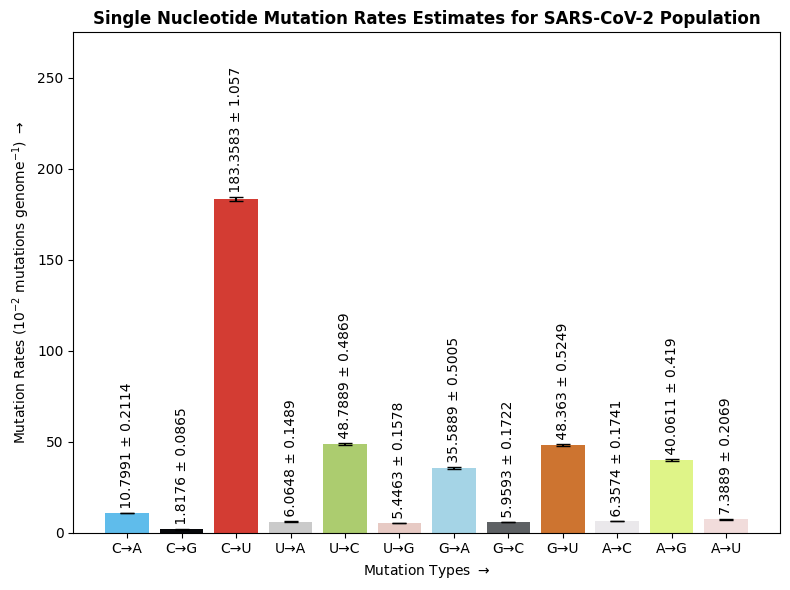

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def plot_single_nucleotide_mutation_rates(single_nucleotide_mutation_rates_for_all_samples):
    e=2

    # To store respective data
    mutation_types = []
    mean_mutation_rates = []
    error_bars = []

    #Calculate the Margin of Errors
    for mutation_type, rates in single_nucleotide_mutation_rates_for_all_samples.items():
        # Compute mean
        mean = np.mean(rates)
        # Get Number of Samples
        n_samples = len(rates)
        # Compute standard Deviation
        std_mutation_rates = np.std(rates, ddof=1) 

        # Get corresponding t-score
        confidence_level = 0.95
        t_score = stats.t.ppf((1 + confidence_level) / 2.0, n_samples - 1)

        # Calculate margin of error
        margin_of_error = t_score * (std_mutation_rates / np.sqrt(n_samples))
        
        # Store the computed values
        mutation_types.append(mutation_type)
        mean_mutation_rates.append(mean)
        error_bars.append(margin_of_error)

    # Define colors for the bars
    colors = ['#5fbceb', '#06070a', '#d33c33', '#cacaca', '#accc6f', '#e7cac4', '#a5d4e6', '#5e6164', '#cd7430', '#eae8eb', '#dff488', '#f1dcdb']

    # Plotting
    plt.figure(figsize=(8, 6))
    #Since it is RNA we replace T with U
    bars = plt.bar([mutation_type.replace("T","U").replace("->", "→") for mutation_type in mutation_types], [mean * 10**e for mean in mean_mutation_rates], yerr=[error * 10**e for error in error_bars], capsize=5, color=colors[:len(mutation_types)])
    plt.xlabel(r'Mutation Types $\rightarrow$')
    plt.ylabel(rf'Mutation Rates ($10^{{-{e}}}$ mutations genome$^{{-1}}$) $\rightarrow$')

    plt.title('Single Nucleotide Mutation Rates Estimates for SARS-CoV-2 Population', fontweight='bold')
    plt.ylim(0, 1.5 * max([mean * 10**e for mean in mean_mutation_rates]))  

    # Adding labels above each bar
    for bar, mean, error in zip(bars, mean_mutation_rates, error_bars):
        plt.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + error* 10**e,  
            f' {round(mean*10**e, 4)} ± {round(error*10**e,4)}', 
            ha='center', va='bottom', fontsize=10, rotation=90
        )

    plt.tight_layout()
    plt.show()

plot_single_nucleotide_mutation_rates(single_nucleotide_mutation_rates_for_all_samples)

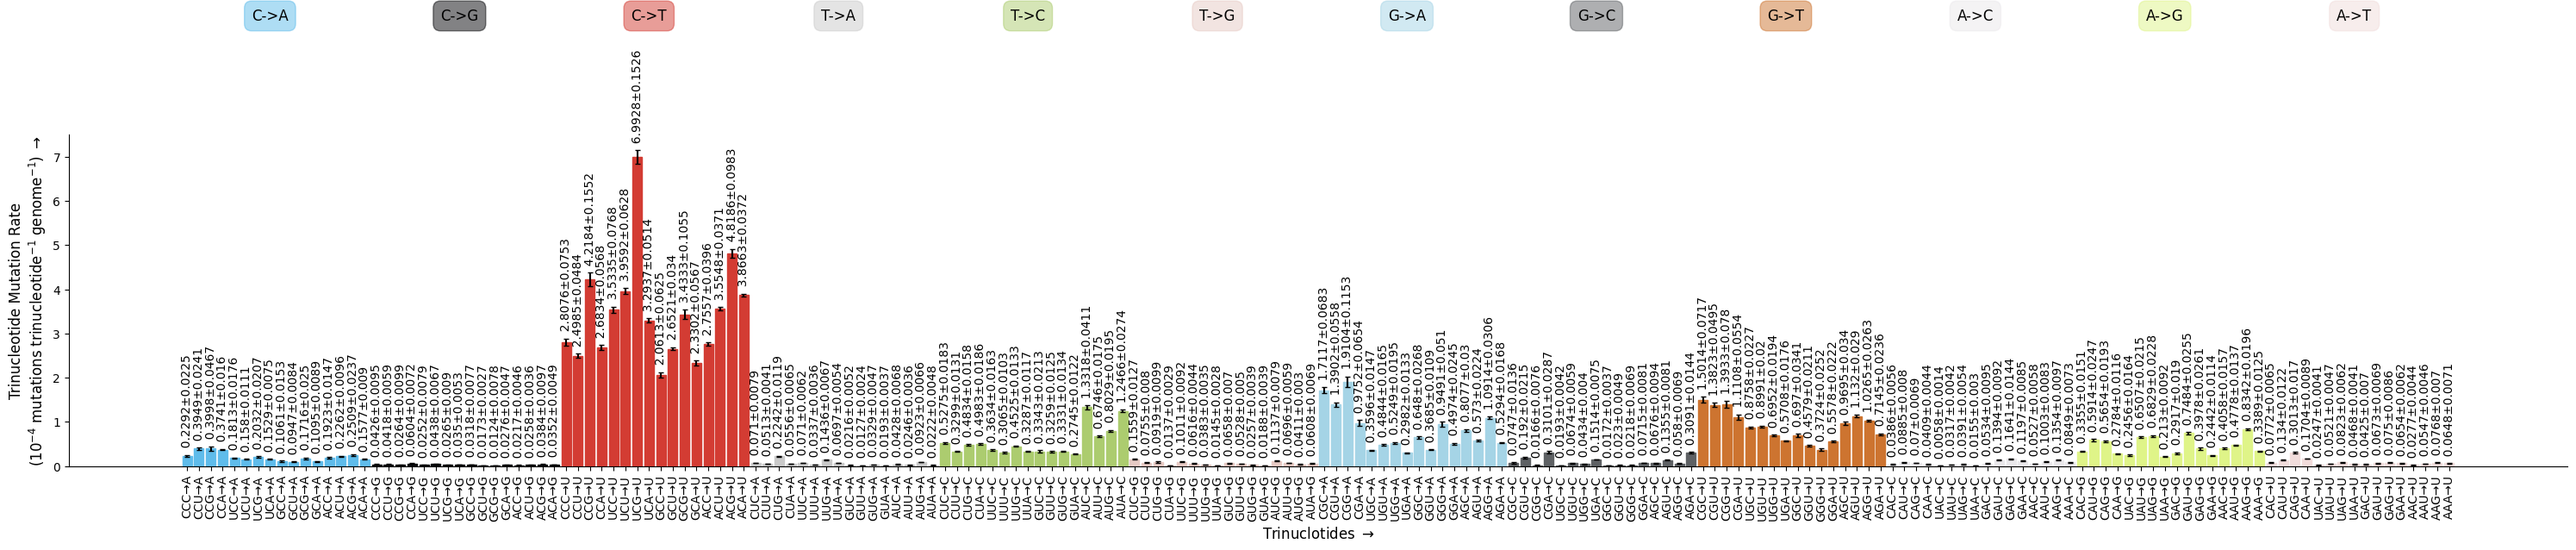

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


e=4

# Step 1: Prepare data
mutation_types = [i[0]+"→"+i[-1] for i in list(trinucleotide_mutation_rates_for_all_samples.keys())]
mean_mutation_rates = [np.mean(trinucleotide_mutation_rates_for_all_samples[trinucleotide_mutation]) for trinucleotide_mutation in list(trinucleotide_mutation_rates_for_all_samples.keys())]  # Mean mutation rates
std_mutation_rates = [np.std(trinucleotide_mutation_rates_for_all_samples[trinucleotide_mutation], ddof=1) for trinucleotide_mutation in list(trinucleotide_mutation_rates_for_all_samples.keys())]  # Standard deviation
n_samples = [len(trinucleotide_mutation_rates_for_all_samples[trinucleotide_mutation]) for trinucleotide_mutation in list(trinucleotide_mutation_rates_for_all_samples.keys())]  # Number of samples for each mutation type

# Confidence level
confidence_level = 0.95
 # t-score for 95% CI
t_score = stats.t.ppf((1 + confidence_level) / 2.0, np.array(n_samples) - 1) 

# Calculate margin of error
margin_of_error = t_score * (np.array(std_mutation_rates) / np.sqrt(n_samples))

# Step 2: Prepare subheadings for grouping
subheadings = [mutation_types[i][1]+"->"+mutation_types[i][-1] for i in range(0, len(mutation_types), 16)]

# Create a color cycle for the bars
colors = ['#5fbceb', '#06070a', '#d33c33', '#cacaca', '#accc6f', '#e7cac4', '#a5d4e6', '#5e6164', '#cd7430', '#eae8eb', '#dff488', '#f1dcdb']
color_cycle = [color for color in colors for _ in range(16)]

# Plotting the bar plot with confidence intervals and cycling colors
plt.figure(figsize=(30, 7))
for i in range(len(mutation_types)):
    # Plot the bar
    bars=plt.bar(mutation_types[i].replace("T","U"), mean_mutation_rates[i]*10**e, color=color_cycle[i], edgecolor=color_cycle[i]) 

    # Add error bars for confidence intervals
    plt.errorbar(mutation_types[i].replace("T","U"), mean_mutation_rates[i]*10**e, yerr=margin_of_error[i]*10**e, fmt='none',  capsize=2, color="black")

    # Add heading at the top middle of every 16 bars
    if (i + 1) % 16 == 8:  # Assuming the middle point is the 8th bar in each group
        bbox_props = dict(boxstyle="round,pad=0.5", edgecolor=color_cycle[i], facecolor=color_cycle[i], alpha=0.5)
        plt.text(i, (max(mean_mutation_rates) + max(margin_of_error))*1.4 *10**e, subheadings[int((i + 1) / 16)],
                 ha='center', va='bottom', fontsize=12, color='black', bbox=bbox_props)

    # Add value (i.e. trinucleotide mutation rates) at the top of each bar
    plt.text(i, (mean_mutation_rates[i] + margin_of_error[i])*10**e, "  " + str(round(mean_mutation_rates[i]*10**e, 4))+ "±"+ str(round(margin_of_error[i]*10**e,4)), ha='center', va='bottom', fontsize=10, rotation=90)

# Plot formatting
plt.xlabel(r'Trinuclotides $\rightarrow$', fontsize=12)
plt.ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$", fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, ha='center', fontsize=10)

# Remove outline at top and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [25]:
trinucleotide_mutation_rate_and_MOE={}
index=0
for trinucleotide_mutation_type in mutation_types:
    trinucleotide=trinucleotide_mutation_type.split("→")[0]
    alternate_base=trinucleotide_mutation_type.split("→")[1]
    if(trinucleotide not in trinucleotide_mutation_rate_and_MOE):
        trinucleotide_mutation_rate_and_MOE[trinucleotide]={}
        trinucleotide_mutation_rate_and_MOE[trinucleotide][alternate_base]=[mean_mutation_rates[index], margin_of_error[index]]
    else:
        trinucleotide_mutation_rate_and_MOE[trinucleotide][alternate_base]=[mean_mutation_rates[index], margin_of_error[index]]

    index+=1


/tmp/ipykernel_4764/3455324391.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_4764/3455324391.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/home/prittam-goswami/anaconda3/lib/python3.12/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x77e1bd987200>' has dtype incompatible with float64, please expli

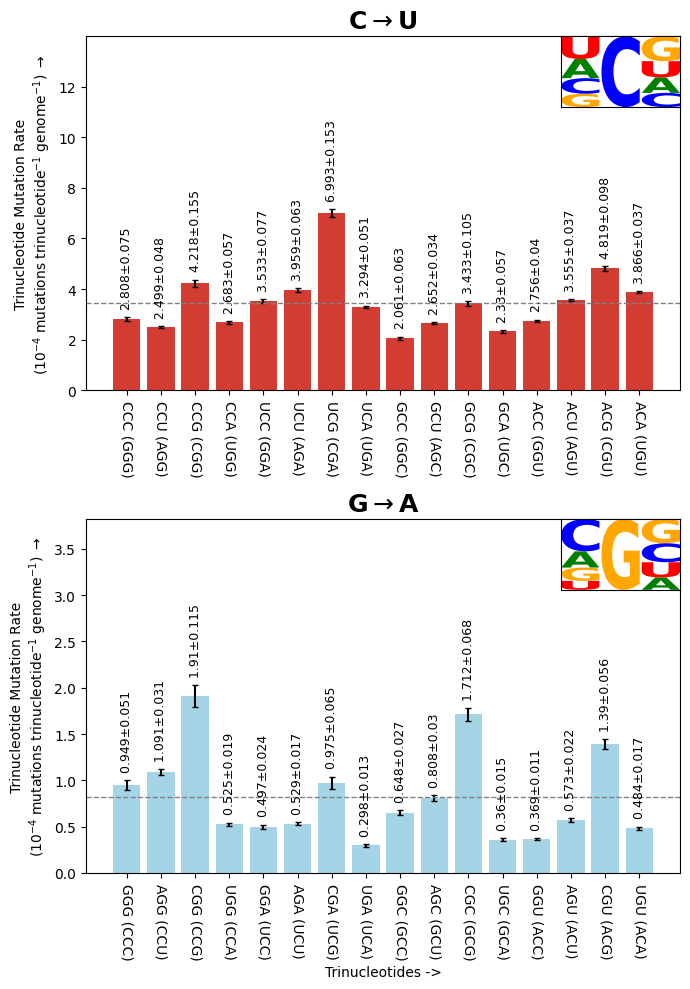

{'CCC': [[0.00028075745386395756, 7.53007905901226e-06], [9.491226412478941e-05, 5.103530274243633e-06]], 'CCT': [[0.00024985199151915204, 4.835089103417297e-06], [0.00010913654024070043, 3.06487510767935e-06]], 'CCG': [[0.0004218377191804677, 1.55152077489852e-05], [0.00019104132882967058, 1.1530277897348982e-05]], 'CCA': [[0.00026834075944478565, 5.683460162681107e-06], [5.249196382566663e-05, 1.9451154988726755e-06]], 'TCC': [[0.0003533463667621123, 7.683076275893827e-06], [4.974208483798827e-05, 2.4470748318418797e-06]], 'TCT': [[0.0003959180714170716, 6.277957086977888e-06], [5.2944965397281484e-05, 1.6801925397249418e-06]], 'TCG': [[0.0006992753498210045, 1.5261231723370765e-05], [9.751783799371841e-05, 6.542460362669068e-06]], 'TCA': [[0.00032936696834413057, 5.143394216050762e-06], [2.9824749156671415e-05, 1.3318135817040836e-06]], 'GCC': [[0.00020613374425236284, 6.254851352696123e-06], [6.480211940886452e-05, 2.6794987904100457e-06]], 'GCT': [[0.0002652067749108738, 3.3982262

/tmp/ipykernel_4764/3455324391.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_4764/3455324391.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/home/prittam-goswami/anaconda3/lib/python3.12/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x77e1bd984c20>' has dtype incompatible with float64, please expli

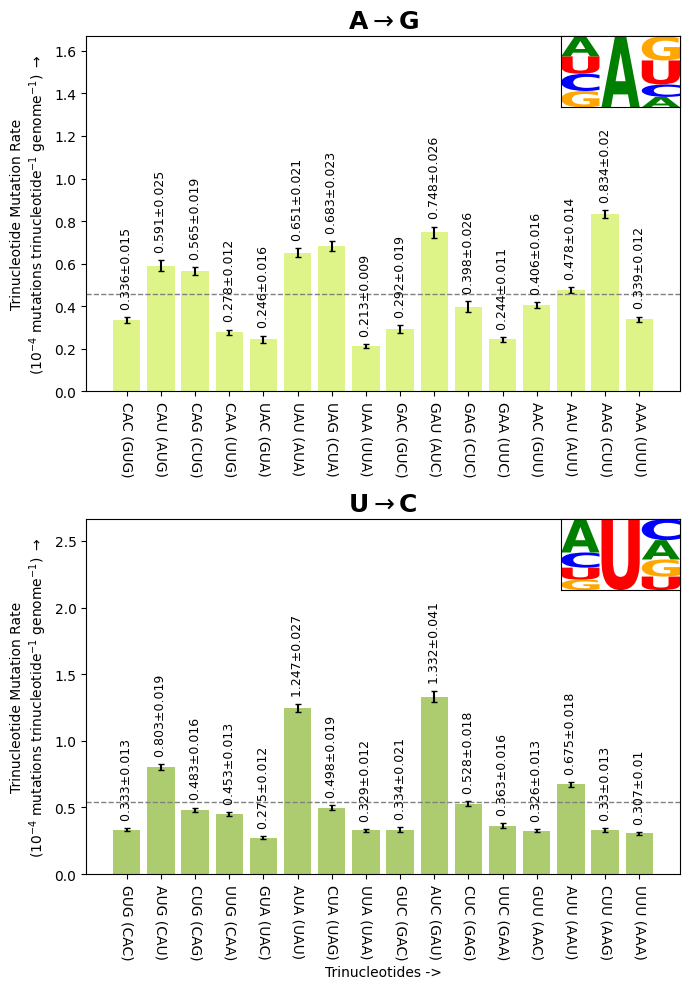

{'CAC': [[3.355422243803457e-05, 1.5115684657799445e-06], [3.331342182597389e-05, 1.3418004654689463e-06]], 'CAT': [[5.914261459969148e-05, 2.46790987859176e-06], [8.028774960205821e-05, 1.949517796805486e-06]], 'CAG': [[5.654198418827248e-05, 1.929594982423637e-06], [4.834343591661023e-05, 1.5765488941733108e-06]], 'CAA': [[2.783613860869363e-05, 1.1627677430937806e-06], [4.525161825447845e-05, 1.328802583382451e-06]], 'TAC': [[2.4562007332230116e-05, 1.6404317972488107e-06], [2.7452838983887694e-05, 1.220238360715239e-06]], 'TAT': [[6.50663639844968e-05, 2.1474995125244956e-06], [0.0001246561907559014, 2.7433191627848606e-06]], 'TAG': [[6.829129195441445e-05, 2.281497524392118e-06], [4.9834182394596264e-05, 1.8560786861663273e-06]], 'TAA': [[2.1298975434931193e-05, 9.229800518251747e-07], [3.286525749273846e-05, 1.16710996341645e-06]], 'GAC': [[2.9165185288645297e-05, 1.8987470095798725e-06], [3.343102054983636e-05, 2.1290100003124422e-06]], 'GAT': [[7.484341051223307e-05, 2.55162729

/tmp/ipykernel_4764/3455324391.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/tmp/ipykernel_4764/3455324391.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
/home/prittam-goswami/anaconda3/lib/python3.12/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x77e1c9667200>' has dtype incompatible with float64, please expli

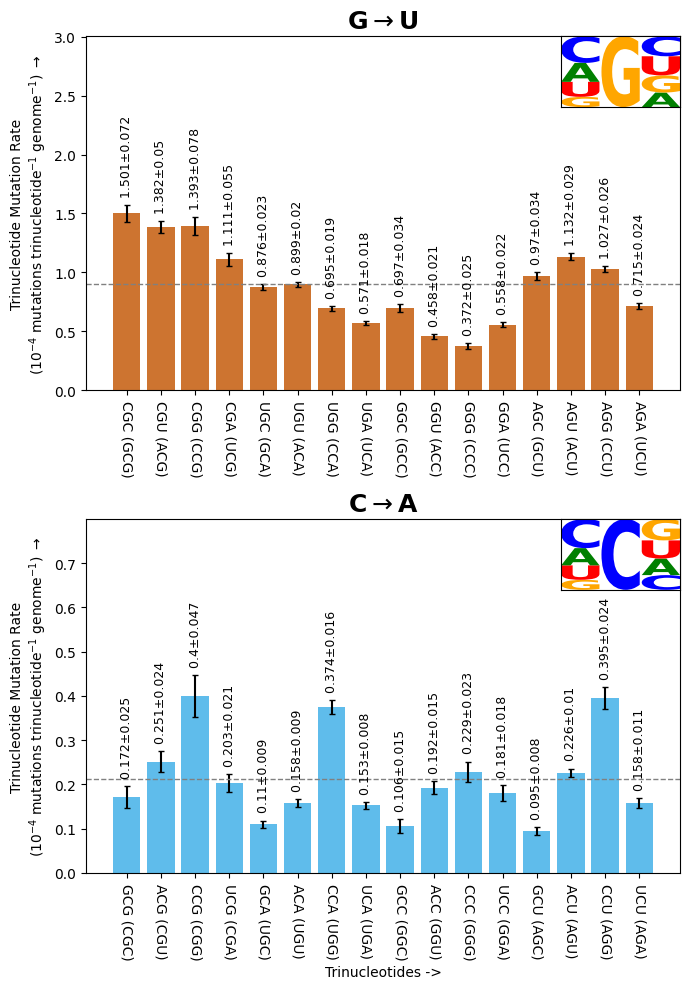

{'CGC': [[0.00015013928724643395, 7.173898866434432e-06], [1.7158817740854375e-05, 2.497121861204931e-06]], 'CGT': [[0.00013823454533534415, 4.951181478871552e-06], [2.508735989628147e-05, 2.367538788586686e-06]], 'CGG': [[0.00013933096086817876, 7.80398990019506e-06], [3.997529106843492e-05, 4.674041693824103e-06]], 'CGA': [[0.00011108452449889537, 5.5383524588127225e-06], [2.0323848601444853e-05, 2.0684753581172043e-06]], 'TGC': [[8.757864088957586e-05, 2.2672155064069093e-06], [1.0953337425823248e-05, 8.90921999938442e-07]], 'TGT': [[8.99050671382766e-05, 1.9991014327771783e-06], [1.5773214433989313e-05, 8.95365545930787e-07]], 'TGG': [[6.952018918277291e-05, 1.9374384169692067e-06], [3.741330038667582e-05, 1.5975080143978901e-06]], 'TGA': [[5.707618357668377e-05, 1.7592444220634288e-06], [1.5285331222506518e-05, 7.502952397643761e-07]], 'GGC': [[6.969912571767136e-05, 3.4063566909820995e-06], [1.060720573396482e-05, 1.526830046978873e-06]], 'GGT': [[4.5788556843920864e-05, 2.105028

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logomaker
from Bio.Seq import Seq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_trinucleotide_mutations_per_strand_bar_plot(count_data, reference_mutation_type, color1, complementary_mutation_type, color2):
    """ 
    Compare complementary mutation types based on trinucleotide mutation rates.
    Plot trinucleotide mutation rates for reference and complementary mutation types in both sorted and unsorted manner,
    and display the Position Weight Matrix (PWM) computed from trinucleotide mutation rates.

    Args: 
    - count_data (dict): Dictionary containing mutation data for trinucleotide sequences.
    - reference_mutation_type (str): The reference mutation type.
    - color1 (str): Color for reference mutation type.
    - complementary_mutation_type (str): The complementary mutation type.
    - color2 (str): Color for complementary mutation type.
    """
    e=4

    fig, ax = plt.subplots(2,1 , figsize=(7, 10))

    # Calculate trinucleotide mutation rates for reference and complementary mutation types
    trinucleotide_mutation_rates = {}
    for trinucleotide in count_data:
        if trinucleotide[1] == reference_mutation_type[0]:
            for alt_base in count_data[trinucleotide]:
                if alt_base == reference_mutation_type[-1]:
                    trinucleotide_mutation_rates[trinucleotide] = [count_data[trinucleotide][alt_base]]
    for trinucleotide in count_data:
        if trinucleotide[1] == complementary_mutation_type[0]:
            for alt_base in count_data[trinucleotide]:
                if alt_base == complementary_mutation_type[-1]:
                    trinucleotide_mutation_rates[str(Seq(trinucleotide).reverse_complement())].append(count_data[trinucleotide][alt_base])

    # Plot the bar plot for the reference mutation type
    bars1 = ax[0].bar(
        [f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
        color=color1)
    
    ax[0].errorbar([f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
                    [trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
                     yerr=[trinucleotide_mutation_rates[polynucleotide][0][1]*10**e for polynucleotide in trinucleotide_mutation_rates], fmt='none',  capsize=2, color="black")

    ax[0].set_ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$")
    ax[0].set_title(reference_mutation_type.replace("T","U"), fontweight='bold', fontsize=18)
    ax[0].set_ylim(0, 2 * max(trinucleotide_mutation_rates[polynucleotide][0][0]*10**e for polynucleotide in trinucleotide_mutation_rates))
    ax[0].set_xticklabels([f"{polynucleotide} ({str(Seq(polynucleotide).reverse_complement())})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)
    
    # Plot the bar plot for the complementary mutation type
    bars2 = ax[1].bar(
        [f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
        color=color2)
    
    ax[1].errorbar([f"{polynucleotide}_{str(Seq(polynucleotide).reverse_complement())}" for polynucleotide in trinucleotide_mutation_rates],
                    [trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates],
                     yerr=[trinucleotide_mutation_rates[polynucleotide][1][1]*10**e for polynucleotide in trinucleotide_mutation_rates], fmt='none',  capsize=2, color="black")

    ax[1].set_ylabel(rf"Trinucleotide Mutation Rate" + "\n"+rf"($10^{{-{e}}}$ mutations trinucleotide$^{{-1}}$ genome$^{{-1}}$) $\rightarrow$")
    ax[1].set_title(complementary_mutation_type.replace("T","U"), fontweight='bold', fontsize=18)
    ax[1].set_xlabel('Trinucleotides ->')
    ax[1].set_ylim(0, 2 * max(trinucleotide_mutation_rates[polynucleotide][1][0]*10**e for polynucleotide in trinucleotide_mutation_rates))
    ax[1].set_xticklabels([f"{str(Seq(polynucleotide).reverse_complement())} ({polynucleotide})".replace("T","U") for polynucleotide in trinucleotide_mutation_rates], rotation=270)


    def add_value_labels(ax, bars, counts, errors):
        for bar, count, error in zip(bars, counts, errors):
            height = bar.get_height() + error*10**e  # Adjust height to include the margin of error
            ax.annotate(f' {round(count*10**e,3)}±{round(error*10**e,3)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90, fontsize=9)

    # Add Trinucleotide Mutation rate value with error margin at the top of each bar in both plots
    add_value_labels(
        ax[0], bars1, 
        [trinucleotide_mutation_rates[polynucleotide][0][0] for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][0][1] for polynucleotide in trinucleotide_mutation_rates]
    )
    add_value_labels(
        ax[1], bars2, 
        [trinucleotide_mutation_rates[polynucleotide][1][0] for polynucleotide in trinucleotide_mutation_rates],
        [trinucleotide_mutation_rates[polynucleotide][1][1] for polynucleotide in trinucleotide_mutation_rates]
    )


        # Add a horizontal line deicting the average trinucleotide mutation rate
    ax[0].axhline(np.mean([bar.get_height() for bar in bars1]), color='grey', linestyle='--', linewidth=1)
    ax[1].axhline(np.mean([bar.get_height() for bar in bars2]), color='grey', linestyle='--', linewidth=1)

    # Compute and normalize PWM for the reference mutation type
    combined_mutation_dict = {
        trinucleotide: count_data[trinucleotide][reference_mutation_type[-1]]
        for trinucleotide in count_data if trinucleotide[1] == reference_mutation_type[0]
    }
    pwm = np.zeros((3, 4))
    for trinucleotide, rate in combined_mutation_dict.items():
        if rate[0] > 0:
            for i, base in enumerate(trinucleotide):
                if base == "A":
                    pwm[i, 0] += rate[0]
                elif base == "C":
                    pwm[i, 1] += rate[0]
                elif base == "G":
                    pwm[i, 2] += rate[0]
                elif base == "T":
                    pwm[i, 3] += rate[0]
    normalized_pwm = pwm / pwm.sum(axis=1, keepdims=True)
    pwm_df = pd.DataFrame(normalized_pwm, index=[i for i in range(1, 4)], columns=["A", "C", "G", "U"])

    # Add PWM inset plot for reference mutation type
    inset_ax = inset_axes(ax[0], width="20%", height="20%", loc='upper right', borderpad=0)
    logo_reference_strand = logomaker.Logo(pwm_df, ax=inset_ax, shade_below=0.5, fade_below=0.5)
     # Remove x and y ticks
    logo_reference_strand.ax.set_xticks([])
    logo_reference_strand.ax.set_yticks([])



    # Repeat for complementary mutation type PWM
    combined_mutation_dict = {
        trinucleotide: count_data[trinucleotide][complementary_mutation_type[-1]]
        for trinucleotide in count_data if trinucleotide[1] == complementary_mutation_type[0]
    }
    pwm = np.zeros((3, 4))
    for trinucleotide, rate in combined_mutation_dict.items():
        if rate[0] > 0:
            for i, base in enumerate(trinucleotide):
                if base == "A":
                    pwm[i, 0] += rate[0]
                elif base == "C":
                    pwm[i, 1] += rate[0]
                elif base == "G":
                    pwm[i, 2] += rate[0]
                elif base == "T":
                    pwm[i, 3] += rate[0]
    normalized_pwm = pwm / pwm.sum(axis=1, keepdims=True)
    pwm_df = pd.DataFrame(normalized_pwm, index=[i for i in range(1, 4)], columns=["A", "C", "G", "U"])


    # Plot PWM for complementary mutation type
    inset_ax = inset_axes(ax[1], width="20%", height="20%", loc='upper right', borderpad=0)
    logo_opposite_strand = logomaker.Logo(pwm_df, ax=inset_ax, shade_below=0.5, fade_below=0.5)
    # Remove x and y ticks
    logo_opposite_strand.ax.set_xticks([])
    logo_opposite_strand.ax.set_yticks([])


    plt.tight_layout()
    plt.show()
    print(trinucleotide_mutation_rates)
e=4
plot_trinucleotide_mutations_per_strand_bar_plot(trinucleotide_mutation_rate_and_MOE,  r"C$\rightarrow$T", '#d33c33', r"G$\rightarrow$A", '#a5d4e6')
plot_trinucleotide_mutations_per_strand_bar_plot(trinucleotide_mutation_rate_and_MOE, r"A$\rightarrow$G", '#dff488', r"T$\rightarrow$C", '#accc6f')
plot_trinucleotide_mutations_per_strand_bar_plot(trinucleotide_mutation_rate_and_MOE, r"G$\rightarrow$T", '#cd7430', r"C$\rightarrow$A", '#5fbceb')